# PAMAP Dataset Creation
In this notebook, we create TS from the PAMAP data archive.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [19]:
import numpy as np
import daproli as dp
import pandas as pd

pd.set_option('display.max_rows', None)

import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

from src.visualization import plot_time_series

First, we need to download the PAMAP data archive from https://www.pamap.org/demo.html and place it into the DATA_PATH folder.

In [3]:
DATA_PATH = "../../archives/PAMAP/"

Now, let's define the relevant data columns that we want to transform to a multivariate TS.

In [4]:
cols = [

    (32, "IMU Shoe X-Acc"),
    (33, "IMU Shoe Y-Acc"),
    (34, "IMU Shoe Z-Acc"),

    (35, "IMU Shoe X-Gyro"),
    (36, "IMU Shoe Y-Gyro"),
    (37, "IMU Shoe Z-Gyro"),

    (38, "IMU Shoe X-Mag"),
    (39, "IMU Shoe Y-Mag"),
    (40, "IMU Shoe Z-Mag"),
]

Next, we define the subjects (1-8) and the mode of operation (indoor / outdoor) we want to use. 

In [5]:
meta = [
    (np.arange(1, 9), "Indoor"),
    (np.arange(2, 9), "Outdoor")
]

Now, we define a helper procedure to extract change points and labels from a series of activities.

In [25]:
def extract_annotations(activities):
    cps = list()
    labels = [activities.iloc[0]]

    for idx in range(1, len(activities)):
        if activities.iloc[idx - 1] != activities.iloc[idx]:
            cps.append(idx)
            labels.append(int(activities.iloc[idx]))

    return np.array(cps, dtype=int), np.array(labels, dtype=int)

Let's write the function to load the requested time series with annotated change points and labels.

In [20]:
def load_pamap_ts(subject, mode, resample_rate=1):
    df = pd.read_csv(f"{DATA_PATH}/{mode}/subject{subject}.dat", sep=" ", header=None)

    #removal of transient activity which it is not used
    df = df.drop(df[df.iloc[:, 1] == 0].index)

    name = f"PAMAP {mode} Subject{subject}"
    cps, labels = extract_annotations(df.iloc[::resample_rate, 1])
    ts = []

    for col, col_name in cols:
        ts.append(df.iloc[::resample_rate, col].to_numpy())

    return name, np.array(ts), cps, labels

Now, let's load the subject data and explore it.

<Figure size 640x480 with 0 Axes>

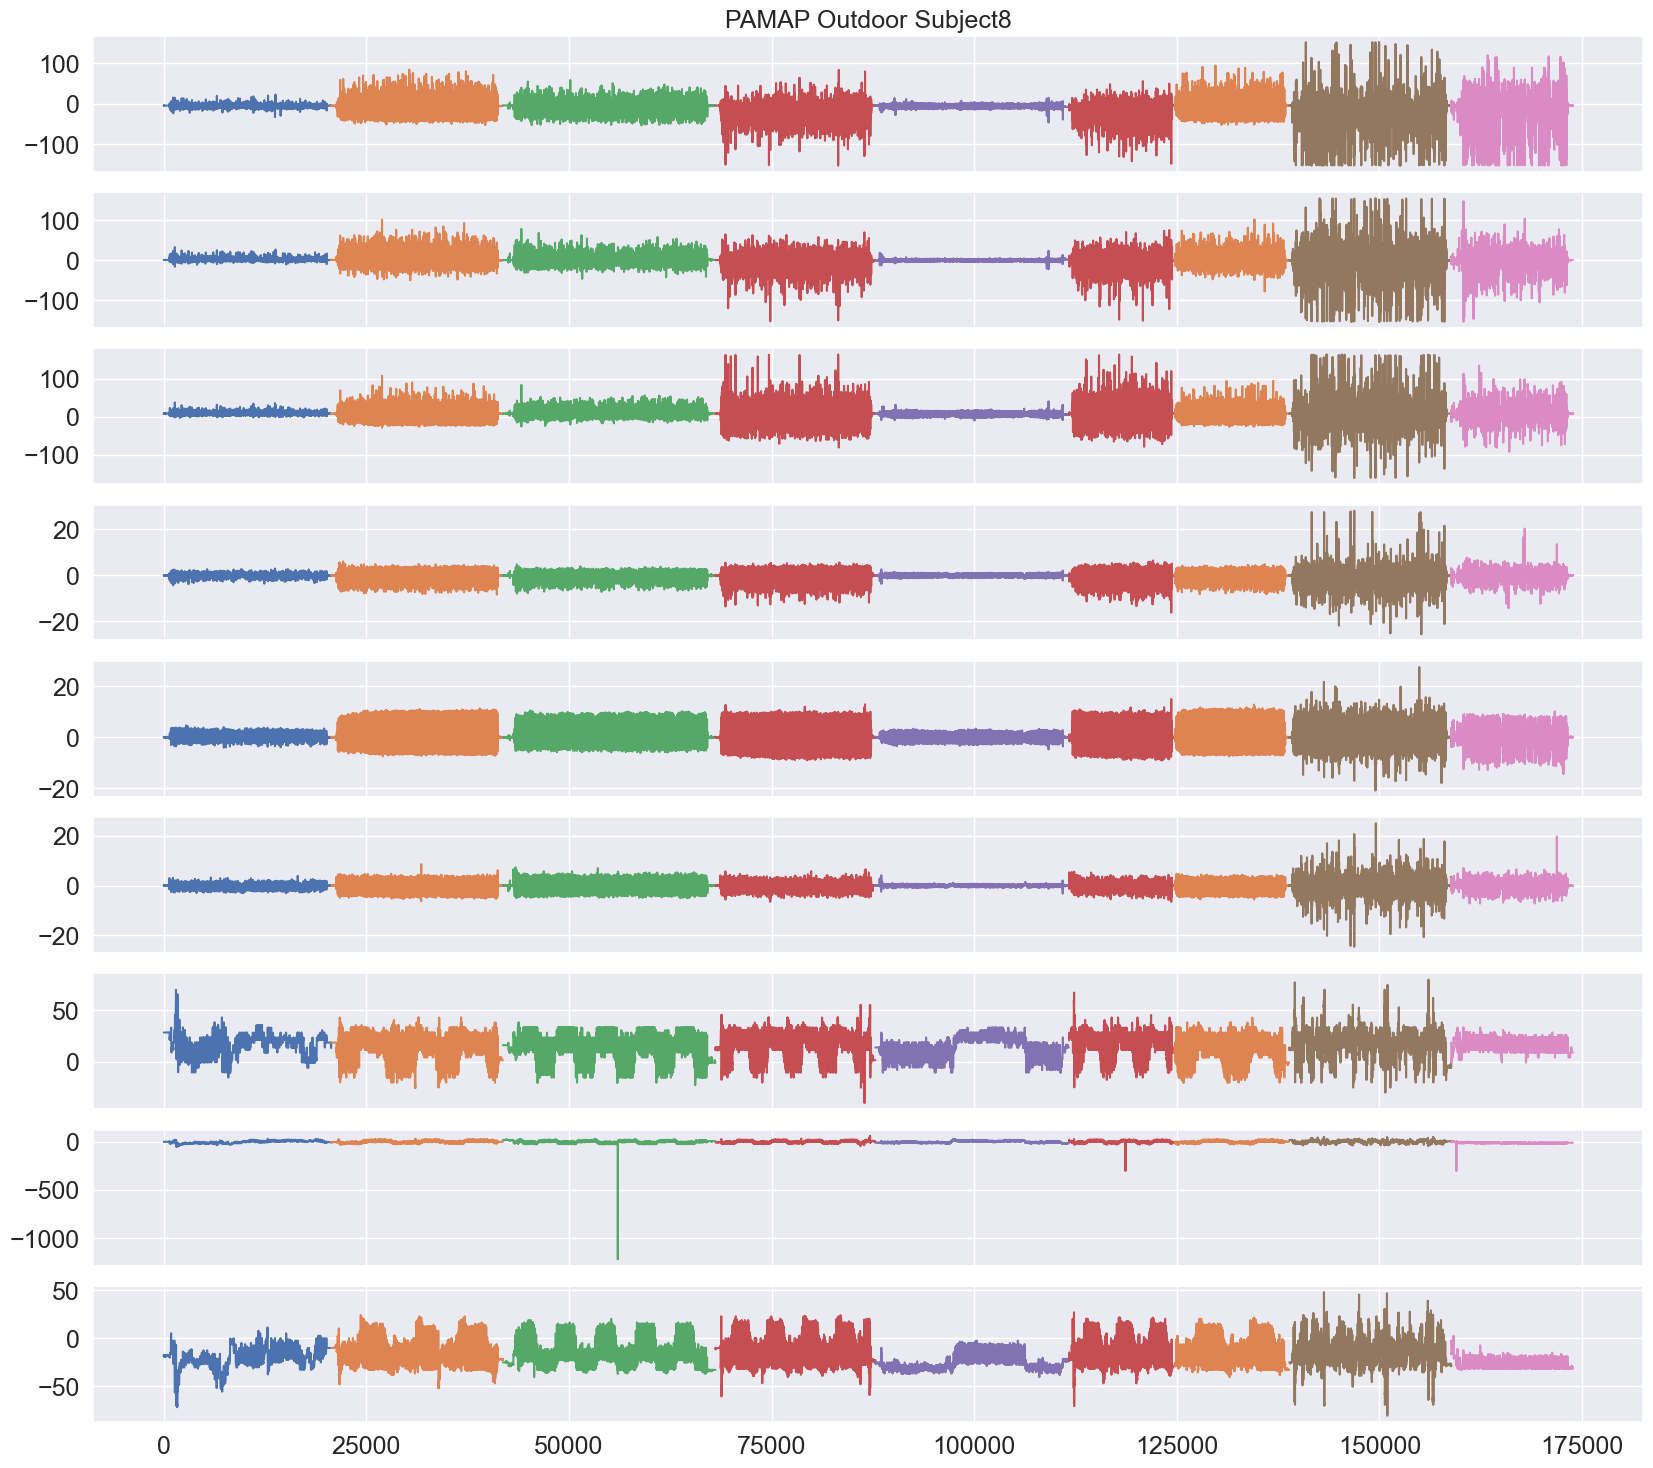

<Axes: >

In [14]:
name, ts, cps, labels = load_pamap_ts(8, "Outdoor")

plot_time_series(
    name,
    ts,
    cps,
    labels,
    show=True
)

Finally, let's create and save the TS dataset.

In [21]:
DATASET_PATH = "../../datasets/PAMAP/"

In [22]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [26]:
desc, prop = [], []
data = dict()
window_size = 100

for subjects, mode in meta:
    for subject in subjects:
        name, ts, cps, labels = load_pamap_ts(subject, mode)

        desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
        prop.append(f"{name},{','.join(dp.map(str, labels))}")
        data[name] = ts.T

np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savetxt(f"{DATASET_PATH}properties.txt", prop, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)